In [1]:
import torch
import torch.nn as nn
import torchvision
from torchinfo import summary         
import numpy as np
import torchvision.transforms as tf
import transformers                    
from tensorboardX import SummaryWriter 
from pkg_resources import packaging    
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from openTSNE import TSNE              
import pandas as pd
import seaborn as sns

from tqdm import tqdm
import random
import re
import time
import math

c:\Users\sunsh\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 2023
random.seed(seed)  
np.random.seed(seed)  
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)  
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.benchmark = False  
torch.backends.cudnn.deterministic = True  

device = torch.device('cuda')

In [3]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

In [4]:
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classification_model = torch.load('model_classification_resnet50.pth')
latent_code_model = torch.load('model_classification_resnet50_withoutfc.pth')

skip to next empty markdown cell

In [6]:
# simple_tf = tf.Compose([
#     tf.PILToTensor(),
#     tf.ConvertImageDtype(torch.float),
#     tf.Resize((224, 224)),#, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
#     tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])

# train_tf = tf.Compose([
#     tf.PILToTensor(),
#     tf.ConvertImageDtype(torch.float),
#     tf.RandomHorizontalFlip(),
#     tf.Resize((224, 224)),#, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
#     # tf.RandomErasing(),
#     tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])

In [7]:
# train_set = torchvision.datasets.CIFAR10("./data", train=True, download=False, transform=train_tf)
# test_set = torchvision.datasets.CIFAR10("./data", train=False, download=False, transform=simple_tf)

In [8]:
# train_dataloader_classification = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False)
# test_dataloader_classification = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

In [9]:
# def extract_data(model, loader, latent_size=2048):
#     data_tensor = torch.zeros((0, latent_size))#.to(device)
#     # label_tensor = torch.zeros((0, 1), dtype=torch.int32)#.to(device)
#     # images_tensor = torch.zeros((0, 3, image_size, image_size), dtype=torch.int32)#.to(device)
#     with torch.no_grad():
#         for images, labels in loader:
#             # images = images.to(device)
#             # labels = labels.to(device).reshape(-1, 1)
#             # images = images
#             # labels = labels.reshape(-1, 1)
#             output = model(images.to(device)).squeeze().cpu()
#             data_tensor = torch.vstack([data_tensor, output])
#             # label_tensor = torch.vstack([label_tensor, labels])
#             # images_tensor = torch.vstack([images_tensor, images])
#             # print('-')

#     # feature_dataset = torch.utils.data.TensorDataset(data_tensor, images_tensor, label_tensor)
#     # feature_loader = torch.utils.data.DataLoader(feature_dataset, batch_size=batch_size, shuffle=True)
    
#     return data_tensor

In [10]:
# train_dataloader_decoder = extract_data(latent_code_model, train_dataloader_classification)
# test_dataloader_decoder = extract_data(latent_code_model, test_dataloader_classification)

In [11]:
# # Specify the file path where you want to save the tensor
# train_dataloader_decoder_path = 'train_data_latent.pth'
# test_dataloader_decoder_path = 'test_data_latent.pth'

# # Save the tensor to the specified file path
# torch.save(train_dataloader_decoder, train_dataloader_decoder_path)
# torch.save(test_dataloader_decoder, test_dataloader_decoder_path)

In [12]:
train_set_latent_coords = torch.load('train_data_latent.pth')
test_set_latent_coords = torch.load('test_data_latent.pth')

In [13]:
simple_tf = tf.Compose([
    tf.PILToTensor(),
    tf.ConvertImageDtype(torch.float),
    # tf.Resize((224, 224)),#, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    # tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_tf = tf.Compose([
    tf.PILToTensor(),
    tf.ConvertImageDtype(torch.float),
    tf.RandomHorizontalFlip(),
    # tf.Resize((224, 224)),#, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    # tf.RandomErasing(),
    # tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [14]:
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=False, transform=train_tf)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=False, transform=simple_tf)

train_dataloader_classification = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False)
test_dataloader_classification = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

In [15]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, input_shape=(2048,)):
        super(Decoder, self).__init__()
        
        # Decoder blocks
        self.decoder_blocks = nn.Sequential(
            self._make_decoder_block(128, 512),
            nn.Upsample(scale_factor=2, mode='nearest'),
            self._make_decoder_block(512, 256),
            nn.Upsample(scale_factor=2, mode='nearest'),
            self._make_decoder_block(256, 256),
            nn.Upsample(scale_factor=2, mode='nearest'),
            self._make_decoder_block(256, 256)
        )
        
        # Final convolution layer
        self.final_conv = nn.Sequential(
            nn.Conv2d(256, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def _make_decoder_block(self, pre_filters, filters):
        return nn.Sequential(
            nn.ConvTranspose2d(pre_filters, filters, kernel_size=3, padding=1),
            nn.LeakyReLU(0.3),
            nn.BatchNorm2d(filters),
            nn.ConvTranspose2d(filters, filters, kernel_size=3, padding=1),
            nn.LeakyReLU(0.3),
            nn.BatchNorm2d(filters),
            nn.ConvTranspose2d(filters, filters, kernel_size=3, padding=1),
            nn.LeakyReLU(0.3),
            nn.BatchNorm2d(filters),
        )

    def forward(self, x):
        x = x.view(x.size(0), 128, 4, 4)
        x = self.decoder_blocks(x)
        x = self.final_conv(x)
        return x

In [16]:
import torch
from torch.utils.data import Dataset

class ZipDataset(Dataset):
    def __init__(self, original_dataset, latent_coords):
        self.original_dataset = original_dataset
        self.latent_coords = latent_coords

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        latent_coord = self.latent_coords[idx]

        return image, latent_coord, label


In [17]:
def train(model, dataloaders, optimizer, **kwargs):
    train_loader, test_loader = dataloaders
    device = kwargs['device']
    loss = nn.MSELoss().to(device)
    model = model.to(device)
    
    for epoch in range(kwargs['max_epochs']):
        ########  Train  ########
        loss_list = []
        model.train()
        last_time = time.time()
        for local_step, (images, latent_coords, labels) in enumerate(train_loader):
            step = epoch * len(train_loader) + local_step
            images, latent_coords, labels = images.to(device), latent_coords.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(latent_coords)
            # print(torch.max(outputs), torch.min(outputs))
            # print(outputs.shape)
            l = loss(outputs, images)
            l.backward()
            optimizer.step()
            
            # log
            loss_list.append(l.detach().cpu().item())
            if (local_step % 100 == 0 and local_step != 0) or local_step == len(train_loader) - 1:
                print("Epoch {}/{} | Step {}/{} | loss:{:.5f} time: {:.1f}s".format(
                    epoch, kwargs['max_epochs'], local_step, len(train_loader),
                    sum(loss_list)/len(loss_list),
                    time.time() - last_time
                ))
                last_time = time.time()
        ########  Test  ########
        loss_list = []
        print("-"*20 + "   Testing   " + "-"*20)
        model.eval()
        with torch.no_grad():
            for local_step, (images, latent_coords, labels) in enumerate(test_loader):
                images, latent_coords, labels = images.to(device), latent_coords.to(device), labels.to(device)
                outputs = model(latent_coords)
                l = loss(outputs, images)
                loss_list.append(l.cpu().item())
            # log
            print("Epoch {}/{} | loss:{:.5f}".format(
                epoch, kwargs['max_epochs'],
                sum(loss_list)/len(loss_list)
            ))
        print("=" * 53)
        mem_report()
        print("=" * 53)
        

In [18]:
batch_size = 512
device = torch.device('cuda')
max_epochs = 20
lr = 0.001

decoder_model = Decoder()

train_set_decoder = ZipDataset(train_set, train_set_latent_coords)
test_set_decoder = ZipDataset(test_set, test_set_latent_coords)

train_dataloader_decoder = torch.utils.data.DataLoader(train_set_decoder, batch_size=64, shuffle=True)
test_dataloader_decoder = torch.utils.data.DataLoader(test_set_decoder, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(decoder_model.parameters(), lr=lr)

train(decoder_model, (train_dataloader_decoder, test_dataloader_decoder), optimizer,
      device=device, max_epochs=max_epochs)

Epoch 0/20 | Step 100/782 | loss:0.05997 time: 13.4s
Epoch 0/20 | Step 200/782 | loss:0.05425 time: 10.2s
Epoch 0/20 | Step 300/782 | loss:0.05078 time: 10.1s
Epoch 0/20 | Step 400/782 | loss:0.04876 time: 10.1s
Epoch 0/20 | Step 500/782 | loss:0.04726 time: 10.0s
Epoch 0/20 | Step 600/782 | loss:0.04613 time: 10.0s
Epoch 0/20 | Step 700/782 | loss:0.04524 time: 9.9s
Epoch 0/20 | Step 781/782 | loss:0.04465 time: 8.0s
--------------------   Testing   --------------------
Epoch 0/20 | loss:0.04031
CPU RAM Free: 1.4 GB
GPU 0 ... Mem Free: 3386MB / 8192MB | Utilization  57%
Epoch 1/20 | Step 100/782 | loss:0.03891 time: 10.0s
Epoch 1/20 | Step 200/782 | loss:0.03855 time: 9.9s
Epoch 1/20 | Step 300/782 | loss:0.03840 time: 9.9s
Epoch 1/20 | Step 400/782 | loss:0.03835 time: 9.8s
Epoch 1/20 | Step 500/782 | loss:0.03811 time: 9.8s
Epoch 1/20 | Step 600/782 | loss:0.03787 time: 9.9s
Epoch 1/20 | Step 700/782 | loss:0.03773 time: 9.9s
Epoch 1/20 | Step 781/782 | loss:0.03759 time: 7.9s
-----

In [19]:
torch.save(decoder_model, 'decoder_model_32.txt')

In [20]:
def get_images_by_category(dataset, category):
    category_indices = [i for i, label in enumerate(dataset.targets) if label == category]
    images = [dataset[i][0] for i in category_indices]
    return images

# Revert the transformations in reverse order
reverted_tf = tf.Compose([
    # tf.Normalize((-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225), (1 / 0.229, 1 / 0.224, 1 / 0.225)),
    # tf.Normalize((0, 0, 0), (1, 1, 1)),  # Unnormalize the tensor
    tf.ConvertImageDtype(torch.uint8),
    tf.ToPILImage(),
])

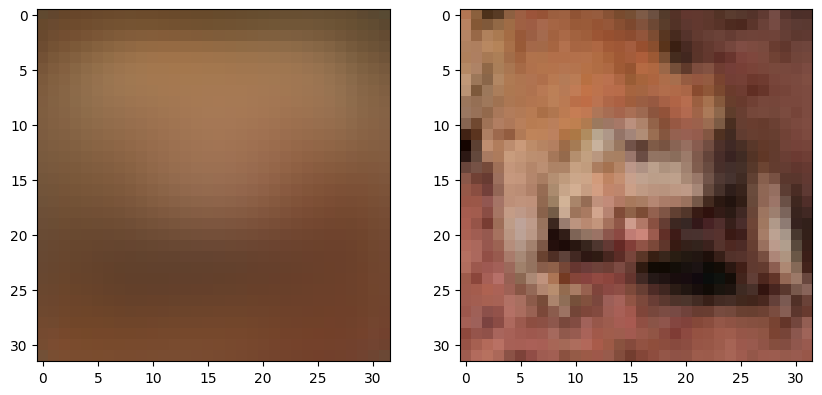

In [27]:
with torch.no_grad():
    i = 5
    plt.figure(figsize=(10, 5))
    output = decoder_model(test_set_latent_coords[i].reshape(1,-1).to(device))
    plt.subplot(1, 2, 1)
    plt.imshow(reverted_tf(output.squeeze()))
    plt.subplot(1, 2, 2)
    plt.imshow(reverted_tf(test_set[i][0]))

add perceptual loss

In [ ]:
to_latent_model_tf = tf.Compose([
    tf.Resize((224, 224)),#, interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
    tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [ ]:
def get_perceptual_loss(model, transform):
    def perceptual_loss(imgs, latent_coords):
        return nn.MSELoss().to(device)(model(transform(imgs)), latent_coords)
    return perceptual_loss

def train(model, dataloaders, optimizer, **kwargs):
    train_loader, test_loader = dataloaders
    device = kwargs['device']
    mse_loss = nn.MSELoss().to(device)
    perceptual_loss = get_perceptual_loss(latent_code_model, to_latent_model_tf)
    model = model.to(device)
    mse_weight, perceptual_weight = kwargs['weights']
    perceptual_weight_decay = kwargs['perceptual_weight_decay']
    
    for epoch in range(kwargs['max_epochs']):
        ########  Train  ########
        loss_list = []
        model.train()
        last_time = time.time()
        for local_step, (images, latent_coords, labels) in enumerate(train_loader):
            step = epoch * len(train_loader) + local_step
            images, latent_coords, labels = images.to(device), latent_coords.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(latent_coords)
            # print(torch.max(outputs), torch.min(outputs))
            # print(outputs.shape)
            l = mse_weights * mse_loss(outputs, images) + perceptual_weight * perceptual_loss(outputs, latent_coords)
            l.backward()
            optimizer.step()
            
            # log
            loss_list.append(l.detach().cpu().item())
            if (local_step % 100 == 0 and local_step != 0) or local_step == len(train_loader) - 1:
                print("Epoch {}/{} | Step {}/{} | loss:{:.5f} time: {:.1f}s".format(
                    epoch, kwargs['max_epochs'], local_step, len(train_loader),
                    sum(loss_list)/len(loss_list),
                    time.time() - last_time
                ))
                last_time = time.time()
        ########  Test  ########
        loss_list = []
        print("-"*20 + "   Testing   " + "-"*20)
        model.eval()
        with torch.no_grad():
            for local_step, (images, latent_coords, labels) in enumerate(test_loader):
                images, latent_coords, labels = images.to(device), latent_coords.to(device), labels.to(device)
                outputs = model(latent_coords)
                l = loss(outputs, images)
                loss_list.append(l.cpu().item())
            # log
            print("Epoch {}/{} | loss:{:.5f}".format(
                epoch, kwargs['max_epochs'],
                sum(loss_list)/len(loss_list)
            ))
        print("=" * 53)
        mem_report()
        print("=" * 53)
        perceptual_weight = max(0, perceptual_weight - perceptual_weight_decay)
        

In [ ]:
batch_size = 512
device = torch.device('cuda')
max_epochs = 20
lr = 0.001
weights = [1, 1]
perceptual_weight_decay = 0.01

decoder_model = Decoder()

train_set_decoder = ZipDataset(train_set, train_set_latent_coords)
test_set_decoder = ZipDataset(test_set, test_set_latent_coords)

train_dataloader_decoder = torch.utils.data.DataLoader(train_set_decoder, batch_size=64, shuffle=True)
test_dataloader_decoder = torch.utils.data.DataLoader(test_set_decoder, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(decoder_model.parameters(), lr=lr)

train(decoder_model, (train_dataloader_decoder, test_dataloader_decoder), optimizer,
      device=device, max_epochs=max_epochs)

In [ ]:
torch.save(decoder_model, 'decoder_model_32_with_perceptual.pth')